Import relevant modules

In [33]:
import numpy as np

import os

import matplotlib.pyplot as plt
%matplotlib inline
from cycler import cycler
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
rcParams.update({'font.size': 15})

# color and linestyle cycle
#colors = [x['color'] for x in list(rcParams['axes.prop_cycle'])]
colors_base = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '0.3', '0.5', '0.75', 'chartreuse']
print 'colors_base', colors_base
colors = [item for sublist in [colors_base]*len(colors_base) for item in sublist] # replicate and flatten
print 'colors', colors, len(list(rcParams['axes.prop_cycle']))

lnstyl = [[l] * len(colors_base) for l in ['-', '--', ':', '.', '-.', '*', 'x']] # replicate per color

print 'lnstyl', lnstyl
lnstyl = [item for sublist in lnstyl for item in sublist] # flatten

plt.rc('axes', prop_cycle=(cycler('color', colors) + cycler('linestyle', lnstyl))) # define cycler

from nideep.eval.learning_curve import LearningCurve
from nideep.eval.eval_utils import Phase

import nideep.eval.log_utils as lu

def moving_avg(x, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(x, window, 'valid')

classnames =  ['alarm', 'baby', 'crash', 'dog', 'engine', 'femaleSpeech', 'fire', 'footsteps',\
               'knock', 'phone', 'piano']
classnames_scalar =  ['alarm', 'baby', 'crash', 'dog', 'engine', 'femaleSpeech', 'fire', 'footsteps', 'general'\
                      'knock', 'phone', 'piano']
print("Done importing")

colors_base ['b', 'g', 'r', 'c', 'm', 'y', 'k']
colors ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k'] 7
lnstyl [['-', '-', '-', '-', '-', '-', '-'], ['--', '--', '--', '--', '--', '--', '--'], [':', ':', ':', ':', ':', ':', ':'], ['.', '.', '.', '.', '.', '.', '.'], ['-.', '-.', '-.', '-.', '-.', '-.', '-.'], ['*', '*', '*', '*', '*', '*', '*'], ['x', 'x', 'x', 'x', 'x', 'x', 'x']]
Done importing


### Merge multiple network definitions that share the same data layers into a single definition to train within the same single process:

In [ ]:
from nideep.proto.proto_utils import Parser
from nideep.nets.net_merge import merge_indep_net_spec

# select network definitions to merge into a single prototxt
# You can also just repeat the same network over and over if you want to train the same network with different random initializations
p0 = './train_val_00.prototxt'
p1 = './train_val_01.prototxt'
p2 = './train_val_02.prototxt'

# load each network definition from file
nets = [Parser().from_net_params_file(p) for p in [p0,p1,p2]]

# merge and save merged prototxt to file
p_dst = './train_val_00_01_02.prototxt'
with open(p_dst, 'w') as f:
    f.write(merge_indep_net_spec(nets))

# use p_dst file in your solver and train this 'network ensemble' like you would any single network.

## After training, we look at the learning curves of the individual sub-networks

Found 3 logs
Train
xD: 538 Train iterations
xE_03: 599 Train iterations
xE_04: 32 Train iterations
Test
xD: 5 Test iterations
xE_03: 5 Test iterations
xE_04: 0 Test iterations


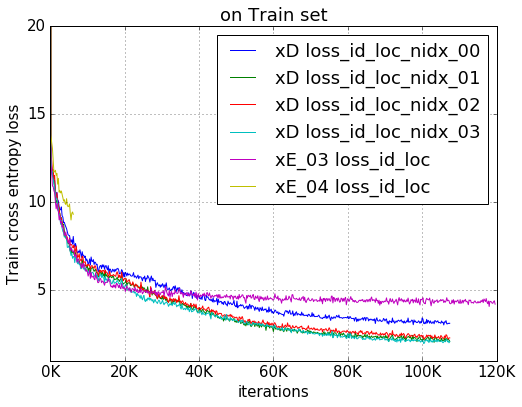

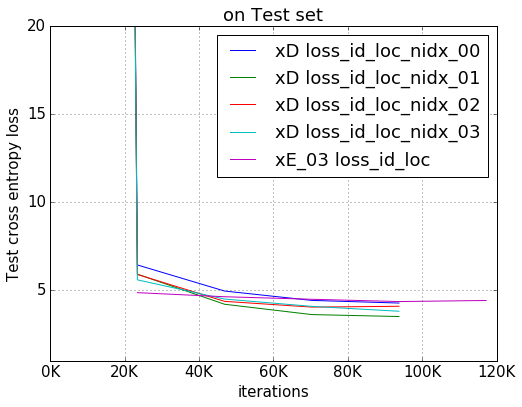

In [97]:
logs = [\
        './xD/caffe.eltanin.kashefy.log.INFO.20160818-105955.20804',
        './xE_03/caffe.eltanin.kashefy.log.INFO.20160818-145600.31621',
        './xE_04/caffe.eltanin.kashefy.log.INFO.20160818-150354.710',
       ]

print("Found %d logs" % (len(logs),))

for phase in [Phase.TRAIN, Phase.TEST]:
    print phase
    plt.figure()
    for p in logs:
        e = LearningCurve(p)
        lc_keys = e.parse()[phase == Phase.TEST]
        num_iter = e.list('NumIters', phase)
        print('%s: %d %s iterations' % (os.path.basename(os.path.dirname(p)), num_iter.size, phase))
        for lck_idx, lck in enumerate(lc_keys):
            if 'nidx' in lck or ('NumIters' not in lck and 'rate' not in lck.lower() and 'seconds' not in lck.lower()):
                try:
                    loss = e.list(lck, phase)
                    plt.plot(num_iter, loss, label='%s %s' % (os.path.basename(os.path.dirname(p)), lck))
                except KeyError as kerr:
                    print("Inavlid values for %s %s" % (phase, lck))
    ticks, _ = plt.xticks()
    plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])

    plt.title(phase)
    plt.xlabel('iterations')
    plt.ylabel(' '.join([phase, 'cross entropy loss']))
    #plt.xlim([0,20e3])
    #plt.xlim([0,300e3])
    plt.ylim([1,20])
    plt.title('on %s set' % phase)
    plt.legend(loc='upper right')
    plt.grid()
